In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2024-09-14 12:14:30.324552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:14:30.324702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:14:30.466325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Downloading The Dataset**

In [2]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/apikey/kaggle.json ~/.kaggle/ # adjust path if needed
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d gargmanas/sentimental-analysis-for-tweets

100%|█████████████████████████████████████████| 476k/476k [00:00<00:00, 832kB/s]
100%|█████████████████████████████████████████| 476k/476k [00:00<00:00, 832kB/s]


In [3]:
df = pd.read_csv('/kaggle/working/sentimental-analysis-for-tweets.zip')
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [4]:
# Rename columns
df.rename(columns={'message to examine': 'Text', 'label (depression result)': 'Label'}, inplace=True)
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [5]:
df.shape

(10314, 3)

In [6]:
# Convert 'Text' column to lowercase
df['Text'] = df['Text'].str.lower()
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Remove HTML Tags</p>**
### ***- The function remove_html_tags accepts a string of text as its parameter.***
### ***- It creates a BeautifulSoup object soup by passing the input text and specifying the parser as `html.parser`. BeautifulSoup is a Python library for parsing `HTML` and `XML` documents.***
### ***- The get_text() method of the BeautifulSoup object is then called to extract the text content from the HTML, excluding any `HTML tags`.***
### ***- The cleaned text without `HTML tags` is returned from the function.***
   ### ***After defining the function, the code applies this function to the `Text` column of a DataFrame named df using the `apply()` method. This effectively `removes HTML tags` from each entry in the `Text` column of the DataFrame.***

In [7]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Remove HTML tags from 'Text' column
df['Text'] = df['Text'].apply(remove_html_tags)

In [8]:
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Remove URLs</p>**
### ***- The regular expression `r'http\S+|www\S+'` matches any sequence of characters that starts with `http` or `www` followed by any non-whitespace characters `(\S+)`.***
### ***- The `re.sub()` function is then used to replace all matches of this pattern in the input text with an empty string, effectively removing them.***
### ***- Finally, the `apply()` function is used to apply this `remove_urls` function to each element in the 'Text' column of the DataFrame `df`, thus removing URLs from all the text entries in that column.***

In [9]:
# Define a function to remove URLs using regular expressions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Apply the function to the 'Text' column
df['Text'] = df['Text'].apply(remove_urls)

In [10]:
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga,0
2,220,@comeagainjen -,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Remove Punctuations</p>**
### ***- `string.punctuation`: This is a predefined string in the Python `string` module that contains all punctuation characters. For example, '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~`.**

### ***- `punctuation = string.punctuation`: This line assigns the string of punctuation characters to the variable `punctuation`.***

### ***- `def remove_punctuation(text)`: This defines a function named `remove_punctuation` that takes a `text` parameter as input.***

### ***- `return text.translate(str.maketrans('', '', punctuation))`: Inside the `remove_punctuation` function, the `translate()` method is used to remove punctuation characters from the input `text`. The `maketrans()` function generates a translation table, and `translate()` applies this table to remove characters.***

### ***- `df['Text'] = df['Text'].apply(remove_punctuation)`: This line applies the `remove_punctuation` function to each element in the 'Text' column of the DataFrame `df` using the `apply()` function. As a result, punctuation characters are removed from each text entry in the 'Text' column.***

In [11]:
string.punctuation

# Define the punctuation characters to remove
punctuation = string.punctuation

In [12]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Apply remove_punctuation function to 'Text' column
df['Text'] = df['Text'].apply(remove_punctuation)

In [13]:
df.head()

,Index,Text,Label
0,106,just had a real good moment i missssssssss him...,0
1,217,is reading manga,0
2,220,comeagainjen,0
3,288,lapcat need to send em to my accountant tomorr...,0
4,540,add me on myspace myspacecomlookthunder,0


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Handling ChatWords</p>**
### ***- The code defines a dictionary named `chat_words` which contains abbreviations commonly used in chat conversations along with their corresponding full forms.***

### ***- Then, a function named `replace_chat_words` is defined, which takes a text input, splits it into individual words, and iterates through each word. If a word is found in the `chat_words` dictionary (after converting it to lowercase), it replaces the word with its full form. Finally, it joins all the words back together into a single string.***

### ***- The `replace_chat_words` function is applied to the 'Text' column of a DataFrame named `df` using the `apply` method, which replaces the chat words in each text entry of the 'Text' column.***

### ***- This code essentially performs text preprocessing by replacing chat abbreviations with their full forms, which can be useful for tasks like sentiment analysis, text classification, or any natural language processing (NLP) task where understanding the full meaning of text is important.***

In [14]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [15]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['Text'] = df['Text'].apply(replace_chat_words)


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Handling StopWords</p>**
### ***- Downloads the stopwords corpus from NLTK (Natural Language Toolkit), which contains a list of common stopwords in English.***
### ***- Imports the stopwords module from NLTK.***
### ***- Defines a function `remove_stopwords(text)` that takes a string of text as input.***
### ***- Within the function, it splits the input text into individual words.***
### ***- Iterates through each word in the text and checks if it is not in the set of English stopwords. If a word is not a stopword, it is added to a list of filtered words.***
### ***- Joins the filtered words back into a single string, separated by spaces, and returns this string.***
### ***- Applies the `remove_stopwords` function to the 'Text' column of the DataFrame `df`.***

In [16]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['Text'] = df['Text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Handling Emojies</p>**
### ***- `emoji.demojize(text)`: This function is part of the `emoji` library in Python. It converts emojis in the input text into their corresponding textual representation. For example, 😀 would be converted to ":grinning_face:".***
### ***- The function `remove_emojis` applies `emoji.demojize()` to the input text, replacing emojis with their textual representations.***
### ***- The modified text with emojis replaced is returned by the function.***
### ***Then, the function `remove_emojis` is applied to the 'Text' column of a DataFrame `df` using the `apply()` method. This ensures that each text entry in the 'Text' column has its emojis removed.***

In [17]:
# Function to remove emojis from text
def remove_emojis(text):
    return emoji.demojize(text)

# Apply remove_emojis function to 'Text' column
df['Text'] = df['Text'].apply(remove_emojis)

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Lemmatization</p>**
### ***- Initialize Lemmatizer: It creates an instance of the WordNetLemmatizer, which is a part of the NLTK library. Lemmatization is the process of reducing words to their base or root form, taking into account their context and meaning.***

### ***- Apply Lemmatization: The 'apply' function is used on the 'Text' column of the DataFrame. For each text in the 'Text' column, the lambda function is applied. This lambda function splits the text into words using the split() method, then lemmatizes each word using the lemmatize() method of the WordNetLemmatizer. The 'pos' parameter is set to 'v' to indicate that the lemmatization should be performed considering the word as a verb.***

### ***- Joining Lemmatized Words: After lemmatization, the words are joined back together into a single string using the 'join' function with a space as the separator. This creates a new column in the DataFrame called 'Text_lemmatized' containing the lemmatized text.***

### ***- Display the Head: Finally, the head() method is used to display the first few rows of the DataFrame with the newly added 'Text_lemmatized' column. This allows you to see the result of the lemmatization process.***

In [18]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Intilize Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Apply 
df['Text_lemmatized'] = df['Text'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in x.split()]))

# Head
df.head()

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

,Index,Text,Label,Text_lemmatized
0,106,real good moment missssssssss much,0,real good moment miss much
1,217,reading manga,0,read manga
2,220,comeagainjen,0,comeagainjen
3,288,lapcat need send em accountant tomorrow oddly ...,0,lapcat need send em accountant tomorrow oddly ...
4,540,add myspace myspacecomlookthunder,0,add myspace myspacecomlookthunder


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Train Test Split</p>**

In [19]:
X = df['Text']
y = df['Label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Tokenization and Padding Sequences</p>**
## ***1. Tokenization:***

### ***- Tokenization is the process of converting text into numerical tokens.***
### ***- `Tokenizer` is initialized with an out-of-vocabulary token `oov_token = 'nothing'`, which will be used to represent out-of-vocabulary words during tokenization.***
### ***- The `fit_on_texts()` method is called on the `Tokenizer` object with the training data `X_train` to build the vocabulary based on the words present in `X_train`.***
### ***- Similarly, the `fit_on_texts()` method is called on the same `Tokenizer` object with the test data `X_test` to ensure consistency in tokenization.***
### ***- `tokenizer.document_count` returns the total number of documents (sentences) processed by the tokenizer.***

## ***2. Conversion to Sequences:***

### ***- `texts_to_sequences()` method is used to convert each text in `X_train` and `X_test` to sequences of integers based on the tokenizer's vocabulary.***
### ***- `X_train_sequences` and `X_test_sequences` now contain sequences of integers representing the words in the original texts.***

## ***3. Padding:***

### ***- The maximum length of sequences in `X_train_sequences` is determined using a list comprehension.***
### ***- `pad_sequences()` function is then applied to both `X_train_sequences` and `X_test_sequences` to ensure all sequences have the same length (`maxlen`) by padding shorter sequences with zeros at the end (post-padding).***
### ***- `maxlen` represents the maximum sequence length found in the training data.***

In [20]:
tokenizer = Tokenizer(oov_token = 'nothing')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [21]:
tokenizer.document_count

10314

In [22]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [23]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 75


In [24]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='pre')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='pre')

In [25]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[    0     0     0 ...   652   908   959]
 [    0     0     0 ...  4059  1215  1645]
 [    0     0     0 ...  6282    20   755]
 ...
 [    0     0     0 ...     0 18977   936]
 [    0     0     0 ...    22    20   679]
 [    0     0     0 ...   894   141   228]]

X_test_padded:
[[    0     0     0 ...  5652   453  2279]
 [    0     0     0 ...   696   182    49]
 [    0     0     0 ...  1268  1982  5416]
 ...
 [    0     0     0 ... 22120 22121 22122]
 [    0     0     0 ...     3   111   101]
 [    0     0     0 ... 22124   626   812]]


#### **<h1 align="center"><span style="color:#2e4f29;">Input Size</span>**
### ***- `X_train_padded` is assumed to be a numpy array containing sequences of integer-encoded tokens, where each token represents a word in the training dataset. These sequences are padded to have the same length.***

### ***- `np.max(X_train_padded)` calculates the maximum integer value present in the `X_train_padded` array. Since these integers represent the token indices, the maximum value corresponds to the highest index used in the vocabulary.***

### ***- Adding 1 to `np.max(X_train_padded)` is necessary because indexing in Python starts from 0. So, if the maximum index in the vocabulary is, for example, 999, then the actual vocabulary size is 1000 (0 to 999 inclusive).***

### ***- Finally, `input_Size` stores the calculated vocabulary size, which will be used as the input size parameter when defining the embedding layer in a neural network model.***

In [26]:
# Embedding Input Size / Vocabulary Size 
input_Size = np.max(X_train_padded) + 1
input_Size

18978

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Model Building</p>**
### ***- `Sequential`: This creates a sequential model, which allows you to stack layers one after the other.***

### ***- `LSTM(128, input_shape=(75,1), return_sequences=True)`: This adds the first LSTM layer to the model. LSTM stands for Long Short-Term Memory, a type of recurrent neural network (RNN) capable of capturing long-term dependencies in data. The layer has 128 units, which means it has 128 memory cells or hidden units. The `input_shape=(75,1)` specifies the input shape of each sample, where 75 is the number of time steps or sequence length, and 1 is the number of features per time step. `return_sequences=True` indicates that this layer should return the full sequence of outputs rather than just the last output.***

### ***- `Dropout(0.5)`: This adds a dropout layer with a dropout rate of 0.5. Dropout is a regularization technique that randomly sets a fraction of input units to zero during training to prevent overfitting.***

### ***- `LSTM(128)`: This adds another LSTM layer with 128 units. Since `return_sequences` is not specified, the default value is `False`, indicating that this layer will only return the last output of the sequence.***

### ***- `Dropout(0.5)`: Another dropout layer is added after the second LSTM layer to further prevent overfitting.***

### ***- `Dense(64, activation='relu')`: This adds a fully connected dense layer with 64 units and ReLU (Rectified Linear Unit) activation function. ReLU is a commonly used activation function that introduces non-linearity to the model.***

### ***- `Dense(1, activation='sigmoid')`: This adds the output layer with a single unit and sigmoid activation function. Sigmoid activation is used for binary classification tasks as it squashes the output between 0 and 1, representing the probability of the positive class.***

In [27]:
# Define the model
model = Sequential()

# Use LSTM instead of SimpleRNN for better capturing long-term dependencies
model.add(LSTM(128, input_shape=(75,1), return_sequences=True))  

# Add dropout regularization
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(LSTM(128)) 

# Add dropout regularization
model.add(Dropout(0.5))  

# Add a dense layer with ReLU activation
model.add(Dense(64, activation='relu'))  

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid')) 

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Compile The Model</p>**
## ***1. Compiling the Model:***

### ***- `model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])`: This line compiles the model by configuring its learning process.***
### ***- `optimizer='adam'`: Specifies the optimization algorithm. Here, it uses the Adam optimizer, which is an efficient optimization algorithm commonly used for training deep learning models.***
### ***- `loss='binary_crossentropy'`: Defines the loss function. For binary classification tasks, binary cross-entropy is a suitable loss function.***
### ***- `metrics=['accuracy']`: Specifies the evaluation metric to monitor during training. Here, it uses accuracy, which measures the proportion of correctly classified samples.***

## ***2. Printing Model Summary:***

### ***- `model.summary()`: This line prints a summary of the model architecture, displaying information such as the type and shape of each layer, the number of parameters, and the output shape of each layer.***

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 75, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Model Training</p>**

In [29]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8042 - loss: 0.4330 - val_accuracy: 0.9161 - val_loss: 0.2280
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9204 - loss: 0.2282 - val_accuracy: 0.9598 - val_loss: 0.1349
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9549 - loss: 0.1576 - val_accuracy: 0.9695 - val_loss: 0.0905
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9653 - loss: 0.1063 - val_accuracy: 0.9661 - val_loss: 0.0805
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9652 - loss: 0.1063 - val_accuracy: 0.9733 - val_loss: 0.0720


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#2e4f29;">Plotting The Loss And Accuracy</p>**

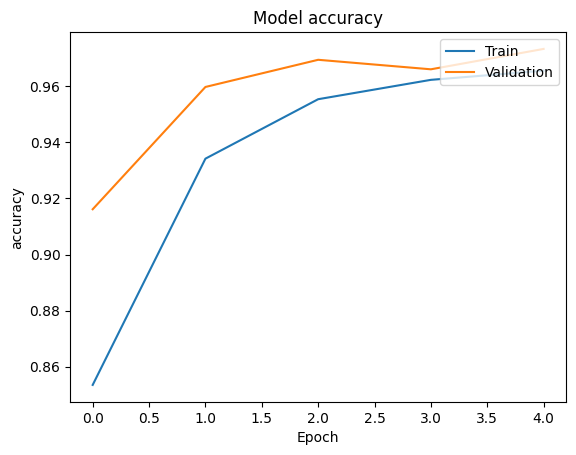

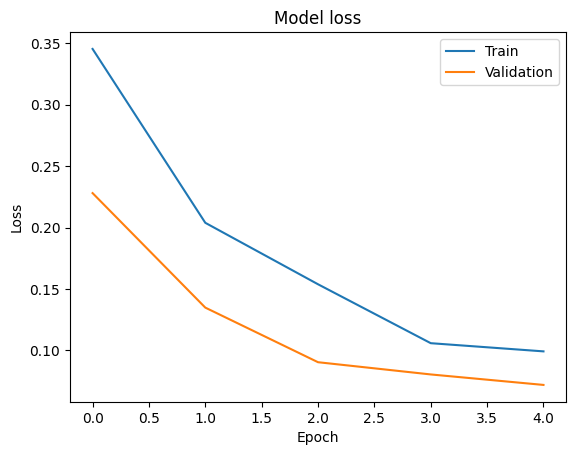

In [30]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

---
# **<p style="font-family:newtimeroman;font-size:200%;text-align:center;color:#2e4f29;">THE END</p>**